In [225]:
### Coding assessment. CryptoCompare 
import pandas as pd
import numpy as np
import requests
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [226]:
### 1. Use python to query for historical BTC and ETH prices for the last 30 days

### Read BTC to USD
url = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym=BTC&tsym=USD'
BTCdata = pd.read_json(url)
BTCprice = pd.DataFrame(BTCdata['Data']['Data'])
BTCprice['date'] = BTCprice['time'].apply(lambda z: datetime.datetime.fromtimestamp(z))

### Read ETH to USD
url = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym=ETH&tsym=USD'
ETHdata = pd.read_json(url)
ETHprice = pd.DataFrame(ETHdata['Data']['Data'])
ETHprice['date'] = BTCprice['time'].apply(lambda z: datetime.datetime.fromtimestamp(z))

print("\nNumber of columns in the dataframe: %i" % (ETHprice.shape[1]))
print("Number of rows in the dataframe: %i\n" % (ETHprice.shape[0]))
columns = list(ETHprice.columns)
print(columns)


Number of columns in the dataframe: 10
Number of rows in the dataframe: 31

['time', 'high', 'low', 'open', 'volumefrom', 'volumeto', 'close', 'conversionType', 'conversionSymbol', 'date']


In [227]:
### a. Which coin performed better in the last 30 days? Calculate the daily returns.
# BTC
BTCprice['close_previous']=BTCprice['close'].shift(1)
BTCprice['return']=(BTCprice['close']-BTCprice['close_previous']).div(BTCprice['close_previous'])
# ETH
ETHprice['close_previous']=ETHprice['close'].shift(1)
ETHprice['return']=(ETHprice['close']-ETHprice['close_previous']).div(ETHprice['close_previous'])
# compare the two 
returns=BTCprice[['time','return']].merge(ETHprice[['time','return']],on='time',how='left',suffixes=('_BTC','_ETH'))
print(returns.head())

         time  return_BTC  return_ETH
0  1651276800         NaN         NaN
1  1651363200    0.022056    0.036326
2  1651449600    0.000844    0.010644
3  1651536000   -0.020451   -0.026431
4  1651622400    0.051817    0.057426


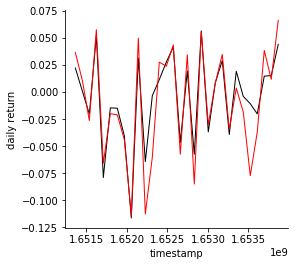

In [228]:
fig=plt.figure(figsize=(4.,4.))
plt.plot(returns['time'],returns['return_BTC'],linewidth=1.,c='k')
plt.plot(returns['time'],returns['return_ETH'],linewidth=1.,c='r')
plt.xlabel('timestamp') ; plt.ylabel('daily return')
plt.tick_params(axis='both',which='both',direction='out')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()
fig.savefig("BTC-ETH.png",dpi=300,bbox_inches='tight')

In [229]:
### b. What was the average, median and standard deviation of daily returns? What conclusions do you get?
returns_stats=returns.copy().dropna()[['return_BTC','return_ETH']].agg(['mean','median','std'])
returns_stats['return_BTC_percent']=100*returns_stats['return_BTC'].apply(lambda z: np.round(z,4))
returns_stats['return_ETH_percent']=100*returns_stats['return_ETH'].apply(lambda z: np.round(z,4))
print(returns_stats)

        return_BTC  return_ETH  return_BTC_percent  return_ETH_percent
mean     -0.005904   -0.010125               -0.59               -1.01
median   -0.001327   -0.007491               -0.13               -0.75
std       0.040778    0.051301                4.08                5.13


In [230]:
### c. Using the same endpoint get XLM-USD last 30 days’ data from the following Crypro exchanges:
### - Coinbase
### - Kraken
### - Bitstamp
### - Binanceusa

### Read XLM - USD
### Coinbase
url = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym=XLM&tsym=USD&e=Coinbase'
XLMdata = pd.DataFrame(pd.read_json(url)['Data']['Data']).assign(e='Coinbase')
### Kraken
url = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym=XLM&tsym=USD&e=Kraken'
XLMdata = pd.concat([XLMdata, pd.DataFrame(pd.read_json(url)['Data']['Data']).assign(e='Kraken')],sort=False)
### Kraken
url = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym=XLM&tsym=USD&e=Kraken'
XLMdata = pd.concat([XLMdata, pd.DataFrame(pd.read_json(url)['Data']['Data']).assign(e='Kraken')],sort=False)
### Bitstamp
url = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym=XLM&tsym=USD&e=Bitstamp'
XLMdata = pd.concat([XLMdata, pd.DataFrame(pd.read_json(url)['Data']['Data']).assign(e='Bitstamp')],sort=False)
### Binanceusa
url = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym=XLM&tsym=USD&e=Binanceusa'
XLMdata = pd.concat([XLMdata, pd.DataFrame(pd.read_json(url)['Data']['Data']).assign(e='Binanceusa')],sort=False)

### Calculate the daily volume-weighted average price (VWAP) for XLM-USD using those 4 exchanges. 
### What conclusions do you get?
XLMdata['close_wavg'] = XLMdata['close'].mul(XLMdata['volumefrom'])  
normalization = XLMdata.groupby(by='e')['volumefrom'].sum().reset_index().rename(columns={'volumefrom':'norm'})
XLMdata = XLMdata.groupby(by='e')['close_wavg'].mean().reset_index()
XLMdata = XLMdata.merge(normalization,on='e',how='left')
XLMdata['close_wavg'] = XLMdata['close_wavg'].div(XLMdata['norm'])

print(XLMdata)

            e  close_wavg          norm
0  Binanceusa    0.004509  1.742972e+08
1    Bitstamp    0.004459  2.114416e+08
2    Coinbase    0.004547  2.957864e+09
3      Kraken    0.002236  3.133974e+08


In [194]:
### 2. Get blockchain data for Bitcoin for the last 30 days
url = 'https://min-api.cryptocompare.com/data/blockchain/histo/day?fsym=BTC'
# print(pd.read_json(url))
# I read this from the website, because somehow the url did not work. 
readout={"Response":"Success","Message":"","Type":100,"RateLimit":{},"Data":{"TimeFrom":1651276800,"TimeTo":1653868800,"Data":[{"id":1182,"symbol":"BTC","time":1651276800,"zero_balance_addresses_all_time":948550063,"unique_addresses_all_time":989611141,"new_addresses":425644,"active_addresses":970531,"transaction_count":261630,"transaction_count_all_time":729915480,"large_transaction_count":15490,"average_transaction_value":14.390323447301,"block_height":734314,"hashrate":221571995.441979,"difficulty":29794407589312.1,"block_time":577.536912751678,"block_size":1227105,"current_supply":19026975},{"id":1182,"symbol":"BTC","time":1651363200,"zero_balance_addresses_all_time":948882433,"unique_addresses_all_time":989993537,"new_addresses":382396,"active_addresses":840129,"transaction_count":232322,"transaction_count_all_time":730147802,"large_transaction_count":14213,"average_transaction_value":17.2895099707965,"block_height":734481,"hashrate":249892443.229479,"difficulty":29794407589312.1,"block_time":512.084337349397,"block_size":874984,"current_supply":19028012},{"id":1182,"symbol":"BTC","time":1651449600,"zero_balance_addresses_all_time":949310161,"unique_addresses_all_time":990417118,"new_addresses":423581,"active_addresses":980280,"transaction_count":272206,"transaction_count_all_time":730420008,"large_transaction_count":18820,"average_transaction_value":23.4079207660361,"block_height":734641,"hashrate":237374963.375915,"difficulty":29794407589312.1,"block_time":539.088050314466,"block_size":1117986,"current_supply":19029012},{"id":1182,"symbol":"BTC","time":1651536000,"zero_balance_addresses_all_time":949714946,"unique_addresses_all_time":990852093,"new_addresses":434975,"active_addresses":952464,"transaction_count":277895,"transaction_count_all_time":730697903,"large_transaction_count":17906,"average_transaction_value":31.7066277136353,"block_height":734791,"hashrate":222339368.951078,"difficulty":29794407589312.1,"block_time":575.543624161074,"block_size":1124335,"current_supply":19029950},{"id":1182,"symbol":"BTC","time":1651622400,"zero_balance_addresses_all_time":950034164,"unique_addresses_all_time":991226726,"new_addresses":374633,"active_addresses":872482,"transaction_count":233045,"transaction_count_all_time":730930948,"large_transaction_count":18107,"average_transaction_value":26.9058384241087,"block_height":734937,"hashrate":218691168.693509,"difficulty":29794407589312.1,"block_time":585.144827586207,"block_size":1092913,"current_supply":19030862},{"id":1182,"symbol":"BTC","time":1651708800,"zero_balance_addresses_all_time":950551514,"unique_addresses_all_time":991718452,"new_addresses":491726,"active_addresses":1174988,"transaction_count":315759,"transaction_count_all_time":731246707,"large_transaction_count":20792,"average_transaction_value":31.5760759945556,"block_height":735094,"hashrate":233048447.532275,"difficulty":29794407589312.1,"block_time":549.096153846154,"block_size":1419433,"current_supply":19031843},{"id":1182,"symbol":"BTC","time":1651795200,"zero_balance_addresses_all_time":951064090,"unique_addresses_all_time":992170041,"new_addresses":451589,"active_addresses":1099911,"transaction_count":286887,"transaction_count_all_time":731533594,"large_transaction_count":20916,"average_transaction_value":29.4080921375522,"block_height":735236,"hashrate":209259682.619344,"difficulty":29794407589312.1,"block_time":611.517730496454,"block_size":1459279,"current_supply":19033125},{"id":1182,"symbol":"BTC","time":1651881600,"zero_balance_addresses_all_time":951387151,"unique_addresses_all_time":992545563,"new_addresses":375522,"active_addresses":840612,"transaction_count":231623,"transaction_count_all_time":731765217,"large_transaction_count":14829,"average_transaction_value":18.5506647644423,"block_height":735379,"hashrate":211098791.579481,"difficulty":29794407589312.1,"block_time":606.19014084507,"block_size":1067810,"current_supply":19033625},{"id":1182,"symbol":"BTC","time":1651968000,"zero_balance_addresses_all_time":951747457,"unique_addresses_all_time":992912541,"new_addresses":366978,"active_addresses":849741,"transaction_count":233892,"transaction_count_all_time":731999109,"large_transaction_count":15338,"average_transaction_value":21.642853369316,"block_height":735534,"hashrate":229073847.523685,"difficulty":29794407589312.1,"block_time":558.623376623377,"block_size":1012209,"current_supply":19034612},{"id":1182,"symbol":"BTC","time":1652054400,"zero_balance_addresses_all_time":952211635,"unique_addresses_all_time":993352640,"new_addresses":440099,"active_addresses":1044085,"transaction_count":279511,"transaction_count_all_time":732278620,"large_transaction_count":22809,"average_transaction_value":28.2872711446401,"block_height":735689,"hashrate":228696355.515465,"difficulty":29794407589312.1,"block_time":559.545454545454,"block_size":1245684,"current_supply":19035825},{"id":1182,"symbol":"BTC","time":1652140800,"zero_balance_addresses_all_time":952625746,"unique_addresses_all_time":993794147,"new_addresses":441507,"active_addresses":985477,"transaction_count":279658,"transaction_count_all_time":732558278,"large_transaction_count":22328,"average_transaction_value":30.372363728688,"block_height":735842,"hashrate":232282798.721346,"difficulty":29822970212378.7,"block_time":551.434210526316,"block_size":1163013,"current_supply":19036518},{"id":1182,"symbol":"BTC","time":1652227200,"zero_balance_addresses_all_time":952985496,"unique_addresses_all_time":994219171,"new_addresses":425024,"active_addresses":1005376,"transaction_count":262683,"transaction_count_all_time":732820961,"large_transaction_count":24735,"average_transaction_value":27.8819338995312,"block_height":735987,"hashrate":227420741.745638,"difficulty":31251101365711.1,"block_time":590.194444444445,"block_size":1238315,"current_supply":19037512},{"id":1182,"symbol":"BTC","time":1652313600,"zero_balance_addresses_all_time":953341861,"unique_addresses_all_time":994672611,"new_addresses":453440,"active_addresses":1043690,"transaction_count":274204,"transaction_count_all_time":733095165,"large_transaction_count":29127,"average_transaction_value":36.5416236440748,"block_height":736122,"hashrate":208816809.271597,"difficulty":31251101365711.1,"block_time":642.776119402985,"block_size":1387405,"current_supply":19038343},{"id":1182,"symbol":"BTC","time":1652400000,"zero_balance_addresses_all_time":953714113,"unique_addresses_all_time":995109508,"new_addresses":436897,"active_addresses":1036736,"transaction_count":269880,"transaction_count_all_time":733365045,"large_transaction_count":25431,"average_transaction_value":25.0551233942071,"block_height":736274,"hashrate":235529990.445041,"difficulty":31251101365711.1,"block_time":569.87417218543,"block_size":1305426,"current_supply":19039231},{"id":1182,"symbol":"BTC","time":1652486400,"zero_balance_addresses_all_time":954204271,"unique_addresses_all_time":995557640,"new_addresses":448132,"active_addresses":1097507,"transaction_count":290225,"transaction_count_all_time":733655270,"large_transaction_count":20778,"average_transaction_value":15.8542076589991,"block_height":736415,"hashrate":217896127.809453,"difficulty":31251101365711.1,"block_time":615.992857142857,"block_size":1396389,"current_supply":19040093},{"id":1182,"symbol":"BTC","time":1652572800,"zero_balance_addresses_all_time":954728967,"unique_addresses_all_time":995924754,"new_addresses":367114,"active_addresses":1022995,"transaction_count":235433,"transaction_count_all_time":733890703,"large_transaction_count":17672,"average_transaction_value":11.8927072843162,"block_height":736537,"hashrate":188935754.512505,"difficulty":31251101365711.1,"block_time":710.413223140496,"block_size":1530435,"current_supply":19040862},{"id":1182,"symbol":"BTC","time":1652659200,"zero_balance_addresses_all_time":955284134,"unique_addresses_all_time":996335672,"new_addresses":410918,"active_addresses":1098098,"transaction_count":272134,"transaction_count_all_time":734162837,"large_transaction_count":22173,"average_transaction_value":16.6912169583122,"block_height":736701,"hashrate":258638854.566057,"difficulty":31251101365711.1,"block_time":518.957055214723,"block_size":1425462,"current_supply":19041887},{"id":1182,"symbol":"BTC","time":1652745600,"zero_balance_addresses_all_time":955781845,"unique_addresses_all_time":996761882,"new_addresses":426210,"active_addresses":1036631,"transaction_count":278496,"transaction_count_all_time":734441333,"large_transaction_count":20986,"average_transaction_value":14.4482389054424,"block_height":736848,"hashrate":230788459.871368,"difficulty":31251101365711.1,"block_time":581.582191780822,"block_size":1460201,"current_supply":19042806},{"id":1182,"symbol":"BTC","time":1652832000,"zero_balance_addresses_all_time":956173770,"unique_addresses_all_time":997165073,"new_addresses":403191,"active_addresses":903949,"transaction_count":262907,"transaction_count_all_time":734704240,"large_transaction_count":20307,"average_transaction_value":11.1975181576813,"block_height":736982,"hashrate":215094909.967606,"difficulty":31251101365711.1,"block_time":624.015037593985,"block_size":1273787,"current_supply":19043643},{"id":1182,"symbol":"BTC","time":1652918400,"zero_balance_addresses_all_time":956527499,"unique_addresses_all_time":997572887,"new_addresses":407814,"active_addresses":902105,"transaction_count":262479,"transaction_count_all_time":734966719,"large_transaction_count":18821,"average_transaction_value":10.4895499640575,"block_height":737104,"hashrate":192594512.527363,"difficulty":31251101365711.1,"block_time":696.917355371901,"block_size":1335489,"current_supply":19044418},{"id":1182,"symbol":"BTC","time":1653004800,"zero_balance_addresses_all_time":956935760,"unique_addresses_all_time":997986025,"new_addresses":413138,"active_addresses":948874,"transaction_count":267034,"transaction_count_all_time":735233753,"large_transaction_count":17952,"average_transaction_value":9.11401360835804,"block_height":737232,"hashrate":198189189.720651,"difficulty":31251101365711.1,"block_time":677.244094488189,"block_size":1443016,"current_supply":19045206},{"id":1182,"symbol":"BTC","time":1653091200,"zero_balance_addresses_all_time":957253112,"unique_addresses_all_time":998338062,"new_addresses":352037,"active_addresses":787760,"transaction_count":225225,"transaction_count_all_time":735458978,"large_transaction_count":13041,"average_transaction_value":6.77646435292983,"block_height":737367,"hashrate":211991813.207859,"difficulty":31251101365711.1,"block_time":633.149253731343,"block_size":1071192,"current_supply":19046056},{"id":1182,"symbol":"BTC","time":1653177600,"zero_balance_addresses_all_time":957558421,"unique_addresses_all_time":998663692,"new_addresses":325630,"active_addresses":751429,"transaction_count":209047,"transaction_count_all_time":735668025,"large_transaction_count":13101,"average_transaction_value":5.68983708611441,"block_height":737489,"hashrate":188173952.100558,"difficulty":31251101365711.1,"block_time":713.289256198347,"block_size":1205588,"current_supply":19046818},{"id":1182,"symbol":"BTC","time":1653264000,"zero_balance_addresses_all_time":957988178,"unique_addresses_all_time":999060264,"new_addresses":396572,"active_addresses":939060,"transaction_count":265106,"transaction_count_all_time":735933131,"large_transaction_count":17809,"average_transaction_value":7.96809581126168,"block_height":737649,"hashrate":247691773.243392,"difficulty":31251101365711.1,"block_time":541.893081761006,"block_size":1142381,"current_supply":19047812},{"id":1182,"symbol":"BTC","time":1653350400,"zero_balance_addresses_all_time":958300947,"unique_addresses_all_time":999425399,"new_addresses":365135,"active_addresses":848460,"transaction_count":235866,"transaction_count_all_time":736168997,"large_transaction_count":17452,"average_transaction_value":10.8730272022319,"block_height":737769,"hashrate":190807221.852055,"difficulty":31251101365711.1,"block_time":703.44537815126,"block_size":1228520,"current_supply":19048568},{"id":1182,"symbol":"BTC","time":1653436800,"zero_balance_addresses_all_time":958786199,"unique_addresses_all_time":999863026,"new_addresses":437627,"active_addresses":1034175,"transaction_count":288842,"transaction_count_all_time":736457839,"large_transaction_count":17331,"average_transaction_value":6.68942713573632,"block_height":737913,"hashrate":219389464.4084,"difficulty":30705864440302.1,"block_time":601.125874125874,"block_size":1354729,"current_supply":19049462},{"id":1182,"symbol":"BTC","time":1653523200,"zero_balance_addresses_all_time":959183129,"unique_addresses_all_time":1000276162,"new_addresses":413136,"active_addresses":910133,"transaction_count":262367,"transaction_count_all_time":736720206,"large_transaction_count":17906,"average_transaction_value":8.84703135806801,"block_height":738054,"hashrate":210522824.573578,"difficulty":29897409688833.6,"block_time":609.949999999999,"block_size":1196357,"current_supply":19050337},{"id":1182,"symbol":"BTC","time":1653609600,"zero_balance_addresses_all_time":959557570,"unique_addresses_all_time":1000704368,"new_addresses":428206,"active_addresses":936015,"transaction_count":270453,"transaction_count_all_time":736990659,"large_transaction_count":19020,"average_transaction_value":10.3896309778332,"block_height":738192,"hashrate":205960970.897811,"difficulty":29897409688833.6,"block_time":623.459854014599,"block_size":1263145,"current_supply":19051206},{"id":1182,"symbol":"BTC","time":1653696000,"zero_balance_addresses_all_time":959880304,"unique_addresses_all_time":1001057685,"new_addresses":353317,"active_addresses":794128,"transaction_count":226794,"transaction_count_all_time":737217453,"large_transaction_count":14932,"average_transaction_value":6.94378327351799,"block_height":738340,"hashrate":221406771.88144,"difficulty":29897409688833.6,"block_time":579.965986394558,"block_size":1055595,"current_supply":19052131},{"id":1182,"symbol":"BTC","time":1653782400,"zero_balance_addresses_all_time":960199577,"unique_addresses_all_time":1001384357,"new_addresses":326672,"active_addresses":757441,"transaction_count":207859,"transaction_count_all_time":737425312,"large_transaction_count":13736,"average_transaction_value":7.25677528116772,"block_height":738489,"hashrate":224702548.401447,"difficulty":29897409688833.6,"block_time":571.45945945946,"block_size":1021936,"current_supply":19053081}]}}
BLCKdata = pd.DataFrame(readout['Data']['Data'])
BLCKdata['date'] = BLCKdata['time'].apply(lambda z: datetime.datetime.fromtimestamp(z))
print(BLCKdata.head())

     id symbol        time  zero_balance_addresses_all_time  \
0  1182    BTC  1651276800                        948550063   
1  1182    BTC  1651363200                        948882433   
2  1182    BTC  1651449600                        949310161   
3  1182    BTC  1651536000                        949714946   
4  1182    BTC  1651622400                        950034164   

   unique_addresses_all_time  new_addresses  active_addresses  \
0                  989611141         425644            970531   
1                  989993537         382396            840129   
2                  990417118         423581            980280   
3                  990852093         434975            952464   
4                  991226726         374633            872482   

   transaction_count  transaction_count_all_time  large_transaction_count  \
0             261630                   729915480                    15490   
1             232322                   730147802                    14213   

         time                date      hashrate     close
0  1651276800 2022-04-30 01:00:00  2.215720e+08  37650.13
1  1651363200 2022-05-01 01:00:00  2.498924e+08  38480.53
2  1651449600 2022-05-02 01:00:00  2.373750e+08  38513.01
3  1651536000 2022-05-03 01:00:00  2.223394e+08  37725.38
4  1651622400 2022-05-04 01:00:00  2.186912e+08  39680.21


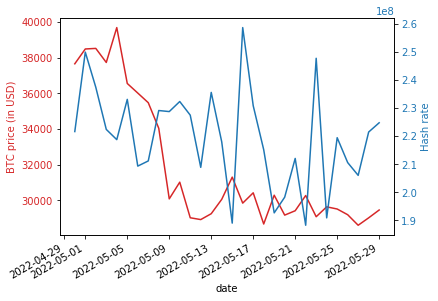

In [218]:
### a. Plot a chart for the Bitcoin price and its hashrate in a dual axis chart, making sure the x-axis is in date format.

forplot=BLCKdata[['time','date','hashrate']].merge(BTCprice[['time','date','close']])
print(forplot.head())

fig, ax = plt.subplots()
color = 'tab:red'
ax.set_xlabel('date')
ax.set_ylabel('BTC price (in USD)', color=color)
ax.plot(forplot['date'], forplot['close'], color=color)
ax.tick_params(axis='y', labelcolor=color)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b %d'))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax2 = ax.twinx()
color = 'tab:blue'
ax2.set_ylabel('Hash rate', color=color)  
ax2.plot(forplot['date'], forplot['hashrate'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.show()
fig.savefig("BTC-hashrate.png",dpi=300,bbox_inches='tight')

In [219]:
### b. What is the correlation of price and hashrate?

correlation=BLCKdata[['time','date','hashrate']].merge(BTCprice[['time','date','close']])
avgs=correlation[['hashrate','close']].mean()
stds=correlation[['hashrate','close']].std()
correlation['hashrate']-=avgs['hashrate']
correlation['close']-=avgs['close']
correlation['product']=correlation['hashrate'].mul(correlation['close'])
rho=correlation['product'].mean()/(stds['hashrate']*stds['close'])
print(rho)

0.22373006124601771
